## [JAX-sim cells] How to simulate 'steady sates' cells based on gene regulatory network build from RNA data.
This simulator is based on Dibaeinia, Payam, and Saurabh Sinha. "SERGIO: a single-cell expression simulator guided by gene regulatory networks." Cell systems 11.3 (2020): 252-271.

1. this notebook can be found in the main repo: https://github.com/ioneliabuzatu/grn-control
2. what is needed to run it:
    1. the graph interactions file e.g. something like this https://github.com/PayamDiba/SERGIO/blob/master/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Interaction_cID_4.txt
    2. the initializations concentrations file of the top nodes of the graph (master regulators) something like this: https://github.com/PayamDiba/SERGIO/blob/master/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Regs_cID_4.txt
3. and then you need the jax_simulator.py found here: https://github.com/ioneliabuzatu/grn-control/blob/main/jax_simulator.py    

In [ ]:
!pip install --upgrade pip

!pip install "jax[cpu]" # check your jax installation here https://github.com/google/jax#installation
!pip install networkx
!pip install matplotlib
!pip install pygraphviz


In [1]:
import time
from jax_simulator import Sim
from collections import namedtuple
import jax.numpy as jnp
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

In [2]:
dataset_namedtuple = namedtuple(
    'dataset',
    ('interactions', 'regulators', 'params_outliers_genes_noise', 'params_library_size_noise', 'params_dropout_noise', 'tot_genes', 'tot_cell_types')
)

In [3]:
NUM_SIM_CELLS = 10 # sets the length of each trajectory
NOISE_AMPLITUDE=0.7 # if set to to zero it will simulate deterministically
TOT_GENES = 100 # number of graph nodes 
TOT_CELL_TYPES = 9 # e.g. healthy vs unhealthy or lung, breast and brain

graph_interactions_filepath = "data/Interaction_cID_4.txt" # graph file
master_regulators_init = "data/Regs_cID_4.txt" # master reglators concentrations at time=0

dataset_dict = {
    "interactions": graph_interactions_filepath,
    "regulators": master_regulators_init,
    "params_outliers_genes_noise": [],
    "params_library_size_noise": [],
    "params_dropout_noise": [],
    "tot_genes": TOT_GENES, 
    "tot_cell_types": TOT_CELL_TYPES
}
dataset = dataset_namedtuple(*dataset_dict.values())

# Init the simulator, build the graph and generate trajectories

In [4]:
sim = Sim(
    num_genes=dataset.tot_genes, 
    num_cells_types=dataset.tot_cell_types,
    simulation_num_steps=NUM_SIM_CELLS,
    interactions_filepath=dataset.interactions, 
    regulators_filepath=dataset.regulators, 
    noise_amplitude=NOISE_AMPLITUDE,
    seed=1234
)

start = time.time()
adjacency, graph, layers = sim.build()
print(f"graph building took: {time.time() - start:.3f} secs.")

start = time.time()
tot_master_regulators = len(layers[0])
actions = jnp.ones((tot_master_regulators, TOT_CELL_TYPES))
trajectory = sim.run_one_rollout(actions=actions)
print(f"simulation took: {time.time() - start:.3f} secs.")

trajectory = jnp.stack(tuple([trajectory[gene] for gene in range(dataset.tot_genes)])).swapaxes(0, 1)
print(f"trajectory shape: {trajectory.shape}")

simulation num step per trajectories:  10
graph building took: 0.386 secs.
action: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
action: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
action: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
action: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
action: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
action: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
action: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
simulation took: 11.365 secs.
trajectory shape: (10, 100, 9)


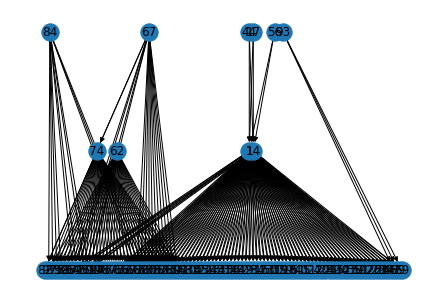

In [9]:
## plot the graph if you want to have a look at it
nx.draw(graph, cmap=plt.get_cmap('jet'), pos=graphviz_layout(graph, prog='dot'), with_labels=True)

### Visualizing the trajectories

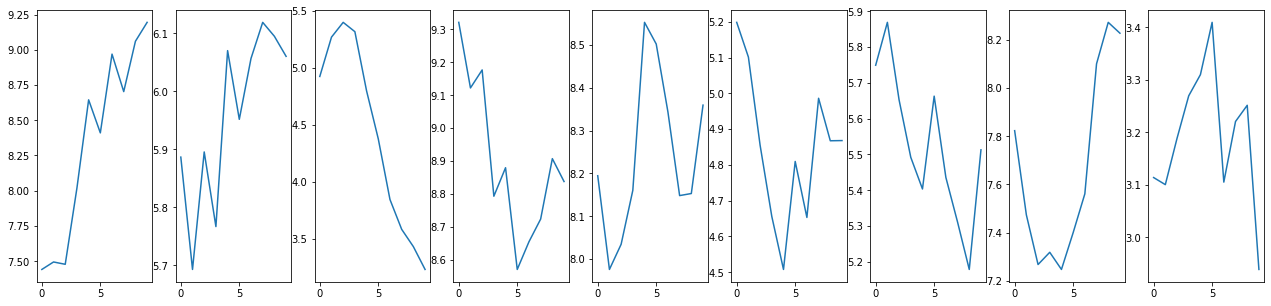

In [57]:
def return_as_jax_primal(gene):
        if isinstance(gene, jax.interpreters.ad.JVPTracer):
            return gene.primal
        return gene
    
def plot(trajectories, axes):
    num_cells, num_genes, num_types = trajectories.shape
    for gene_idx in range(num_genes):
        if gene_idx in [1]:
            for cell_idx in range(num_types):
                subplot = axes[cell_idx]
                subplot.plot(return_as_jax_primal(trajectories[:, gene_idx, cell_idx]))
                        
    plt.show()
    
    
_, axes = plt.subplots(1, dataset.tot_cell_types, figsize=(22, 5))     
plot(trajectory, axes)